# I. Preparation

In [1]:
import os
import h5py
import time
import itertools

from math import log, sqrt
from statistics import stdev, variance, mean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal
from scipy.stats import ttest_ind

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

from fooof import FOOOF, FOOOFGroup
from fooof.plts.spectra import plot_spectrum, plot_spectrum_shading, plot_spectra, plot_spectra_shading
from fooof.analysis import get_band_peak_fm, get_band_peak_fg
from fooof.plts.periodic import plot_peak_fits, plot_peak_params
from fooof.plts.aperiodic import plot_aperiodic_params, plot_aperiodic_fits
from fooof.objs.utils import combine_fooofs

from neurodsp.filt import filter_signal
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum

## 1. Function to read .mat files

In [2]:
def read_matlab(filename):
    def conv(path=''):
        p = path or '/'
        paths[p] = ret = {}
        for k, v in f[p].items():
            if type(v).__name__ == 'Group':
                ret[k] = conv(f'{path}/{k}')  # Nested struct
                continue
            v = v[()]  # It's a Numpy array now
            if v.dtype == 'object':
                # HDF5ObjectReferences are converted into a list of actual pointers
                ret[k] = [r and paths.get(f[r].name, f[r].name) for r in v.flat]
            else:
                # Matrices and other numeric arrays
                ret[k] = v if v.ndim < 2 else v.swapaxes(-1, -2)
        return ret

    paths = {}
    with h5py.File(filename, 'r') as f:
        return conv()

## 2. Parameters that can be changed

In [3]:
# Days
days = ('/Day1', '/Day2')

# Subjects
subjects = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 
            'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 
            'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30']

In [4]:
# Parieto, parieto-occipital and occipital channels
channels = (17,18,19,20,21,22,23,24,25,26,27,29,30)
n_channels = 13

In [5]:
table = 3

# Frequency range to fit FOOOF model: Low, Mid, or High
fr = (10, 50)

# Frequency range from which to collect Gaussians
bn = (18,24)

## 3. Parameters that should stay fixed

In [6]:
# Sampling rate
fs = 200

# nperseg
nperseg = 500

# Set peak_width_limits
pwl = [2, 4]

# Set max_n_peaks
mnp = 5

# Set peak_threshold
pt = 2 

# Initialize dataframe to store variables
df = pd.DataFrame([], index = [], columns = ['subject', 'day', 'target', \
                                             'offset', 'knee', 'exponent', \
                                             'CF', 'PW', 'BW', 'n_peaks', \
                                             'r_squared', 'error'])

# Colors
colors = ['blue', 'yellow', 'green', 'red']

# II. Fourier transform and FOOOF

In [7]:
## Read EEG, calculate PSD (Welch), fit FOOOF

tic = time.time()
for subject in subjects: 
    for day in days:
        # Initialize per target, average over trials and channels
        powers_50 = np.empty((0, int(nperseg//2)+1), float)
        powers_55 = np.empty((0, int(nperseg//2)+1), float)
        powers_60 = np.empty((0, int(nperseg//2)+1), float)
        powers_65 = np.empty((0, int(nperseg//2)+1), float)
        powers_210 = np.empty((0, int(nperseg//2)+1), float)
        powers_215 = np.empty((0, int(nperseg//2)+1), float)
        powers_220 = np.empty((0, int(nperseg//2)+1), float)
        powers_225 = np.empty((0, int(nperseg//2)+1), float)
        powers_400 = np.empty((0, int(nperseg//2)+1), float)
        powers_405 = np.empty((0, int(nperseg//2)+1), float)
        powers_410 = np.empty((0, int(nperseg//2)+1), float)
        powers_415 = np.empty((0, int(nperseg//2)+1), float)

        # Change working directory
        original = os.getcwd()
        os.chdir("C:/Users/ThinkPad/Desktop/Thesis/Data/"+subject+day)

        # Giving directory name
        folderdir = 'C:/Users/ThinkPad/Desktop/Thesis/Data/'+subject+day

        # Giving file extensions
        ext = ('.mat')

        # Iterating over directory
        for path, dirc, files in os.walk(folderdir):
            for file in files:
                if file.endswith(ext) and file.startswith('cnt'):
                    print(subject, day, file)

                    # LOW, MID, or HIGH
                    level = file[4:-7]

                    # Session 1, or session 2
                    session = file[-6]

                    # Read data
                    data = read_matlab(file)['cnt']['x']

                    # Read timestamps 
                    timestamps = (read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['time'])[0]

                    # Read stimuli order
                    order_stimuli = read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['event']['desc']

                    for trial, timestamp in enumerate(timestamps):   
                        if trial%2 == False:
                            start = int(timestamp)
                        else:
                            stop = int(timestamp)

                            for channel in channels:
#                                 # Apply bandpass filter
#                                 data[:,channel] = filter_signal(data[:,channel], fs, 'bandpass', f_range=fr)

                                # Splice data according to timestamps
                                sig = data[:,channel][start:stop]
                                times = create_times(len(sig)/fs, fs)

#                                 # Plot EEG 
#                                 fig, ax = plt.subplots(figsize=[15, 5])
#                                 plot_time_series(times, sig, xlim=[0,len(sig)/fs], ax=ax)
#                                 plt.show()                                

                                # Welch FFT: calculate mean of spectrogram
                                freq, power = signal.welch(sig, fs, window='hann', average='mean', nperseg=nperseg,\
                                                          noverlap=450, detrend='constant')

                                # Append power to previous powers
                                if level=='LOW':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_50 = np.append(powers_50, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_55 = np.append(powers_55, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_60 = np.append(powers_60, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_65 = np.append(powers_65, power.reshape(1, len(freq)), axis=0)
                                elif level=='MID':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_210 = np.append(powers_210, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_215 = np.append(powers_215, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_220 = np.append(powers_220, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_225 = np.append(powers_225, power.reshape(1, len(freq)), axis=0)
                                elif level=='HIGH':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_400 = np.append(powers_400, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_405 = np.append(powers_405, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_410 = np.append(powers_410, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_415 = np.append(powers_415, power.reshape(1, len(freq)), axis=0)
                                        
        # Fit FOOOF model per target
        for (powers, target) in zip((powers_210, powers_215, powers_220, powers_225), \
                                    (210, 215, 220, 225)):
            # FOOOF object: initialize, fit and print results
            fm = FOOOF(aperiodic_mode='knee', peak_width_limits=pwl, max_n_peaks=mnp, peak_threshold=pt, verbose=True)
            fm.fit(freq, np.mean(powers, axis=0), freq_range=fr)
            fm.print_results()
#             fig, ax = plt.subplots(figsize=[15, 5])
#             fm.plot(plot_peaks='line-shade', ax=ax)
#             plt.show()

            # Save metadata, FOOOF parameters and results
            try:
                if np.isnan(get_band_peak_fm(fm, band=bn, select_highest=True)[0])==False:
                    row = pd.DataFrame([subject, day, target, \
                                        fm.aperiodic_params_[0], \
                                        fm.aperiodic_params_[1], \
                                        fm.aperiodic_params_[2], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[0], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[1], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[2], \
                                        fm.n_peaks_,\
                                        fm.r_squared_, \
                                        fm.error_],
                                       index = ['subject', 'day', 'target', \
                                                'offset', 'knee', 'exponent',\
                                                'CF', 'PW', 'BW', 'n_peaks', \
                                                'r_squared', 'error']).transpose()
                    df = df.append(row, ignore_index=True) 
            except:
                pass

# Typecast dataframe
df[['subject', 'day', 'target']] = df[['subject', 'day', 'target']].astype('category')
df['n_peaks'] = df['n_peaks'].astype('int32')
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']] = \
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']].astype('float32')

# Change working directory back
os.chdir(original)

print(f'Done in {time.time()-tic} seconds')

S1 /Day1 cnt_HIGH(1).mat
S1 /Day1 cnt_HIGH(2).mat
S1 /Day1 cnt_LOW(1).mat
S1 /Day1 cnt_LOW(2).mat
S1 /Day1 cnt_MID(1).mat
S1 /Day1 cnt_MID(2).mat
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 10 - 50 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -2.7861, -1.0137, 0.0059                                     
                                                              

# III. Descriptive statistics
## 1. Summary

In [8]:
# Data types
display(df.dtypes)

subject      category
day          category
target       category
offset        float32
knee          float32
exponent      float32
CF            float32
PW            float32
BW            float32
n_peaks         int32
r_squared     float32
error         float32
dtype: object

In [9]:
# Head of dataframe
display(df.head(n=5))

,subject,day,target,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
0,S1,/Day1,210,-2.786069,-1.013677,0.005934,19.586790,0.252773,3.550318,3,0.971973,0.044624
1,S1,/Day1,215,-3.434262,-1.003559,0.001554,20.185457,0.223581,3.162583,3,0.973995,0.044684
2,S1,/Day1,220,-1.130506,-1.598865,0.205102,21.920685,0.298087,2.000000,3,0.971127,0.049268
3,S1,/Day1,225,-4.173462,-1.000673,0.000297,20.296577,0.213252,4.000000,5,0.969226,0.047616
4,S1,/Day2,210,-3.396288,-1.002890,0.001265,18.440058,0.231410,2.214785,4,0.966493,0.044092


In [10]:
# Summary statistics
display(pd.concat([df.describe(),\
                   pd.DataFrame(df.skew(), columns=['skewness']).transpose(),\
                   pd.DataFrame(df.kurtosis(), columns=['kurtosis']).transpose()]).round(2))

,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
count,233.00,2.330000e+02,233.00,233.00,233.00,233.00,233.00,233.00,233.00
mean,1.87,9.353740e+08,1.81,21.57,0.34,2.66,3.48,0.95,0.06
std,2.46,1.315607e+10,1.27,0.90,0.15,0.82,1.01,0.05,0.02
min,-4.27,-2.790800e+02,0.00,18.31,0.09,2.00,1.00,0.58,0.03
25%,0.43,-8.090000e+00,0.83,21.04,0.24,2.00,3.00,0.95,0.05
50%,1.77,-1.600000e+00,1.71,21.67,0.32,2.01,4.00,0.97,0.05
75%,3.54,4.612600e+02,2.62,22.18,0.43,3.48,4.00,0.98,0.06
max,10.91,2.004331e+11,7.07,23.85,1.00,4.00,5.00,0.99,0.13
skewness,0.21,1.516000e+01,1.07,-0.69,1.19,0.70,-0.14,-3.99,1.19
kurtosis,1.61,2.308400e+02,2.15,1.33,2.51,-1.27,-0.90,22.05,1.49


## 2. Univariate plots

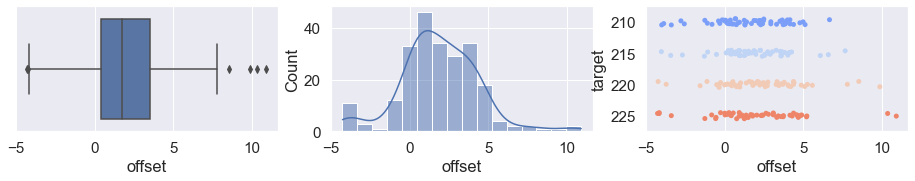

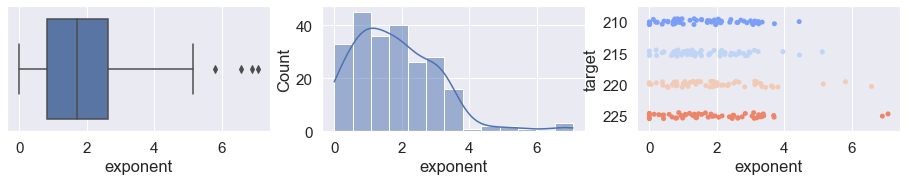

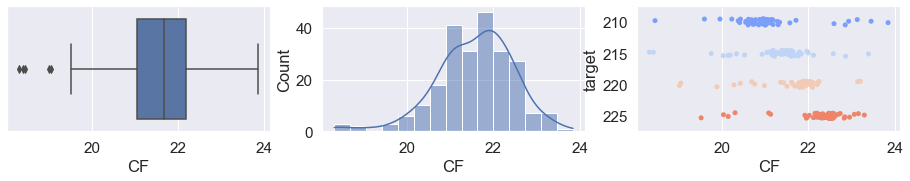

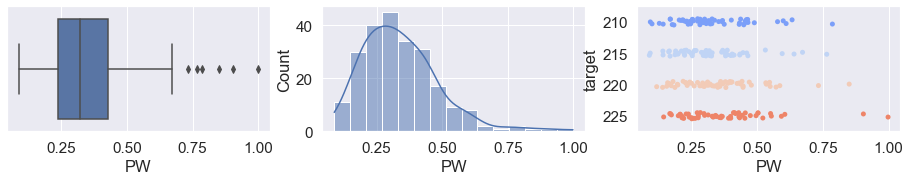

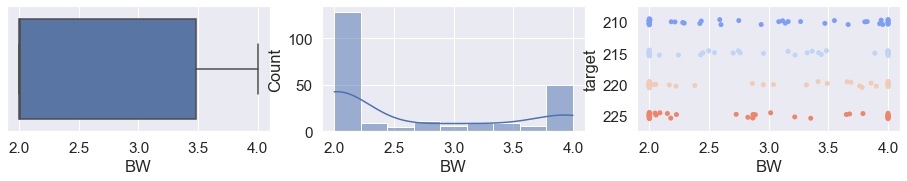

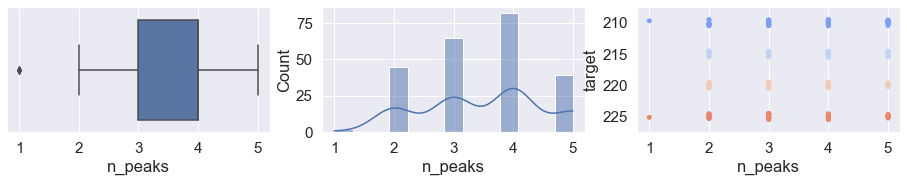

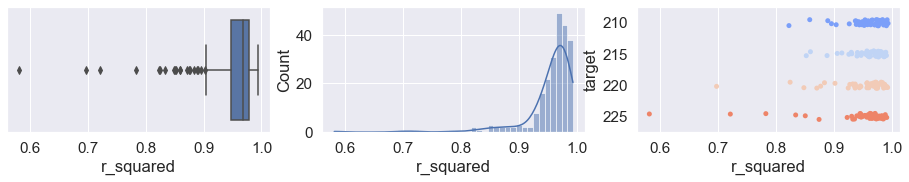

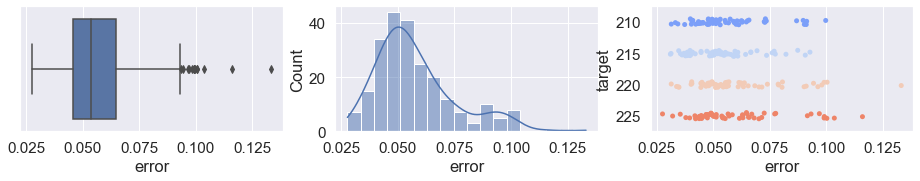

Done in 8.885s


In [11]:
tic = time.time()

df_num = df[['offset', 'exponent', 'CF', 'PW', 'BW', 'n_peaks', 'r_squared', 'error']]

for index, column in enumerate(df_num):
    sns.set(font_scale = 1.38)
    fig, ax = plt.subplots(1, 3, figsize=[16, 2.3])
    sns.boxplot(data=df_num, x=column, ax=ax[0])
    sns.histplot(data=df_num, x=column, kde=True,  ax=ax[1]) 
    sns.stripplot(data=df_num, x=column, y=df['target'], palette='coolwarm', ax=ax[2])
    plt.show()

toc = time.time()
print(f"Done in {toc - tic:.3f}s")

## 3. Bivariate plots

C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
C:\Users\ThinkPad\anaconda3\lib\site-packages\seaborn\distributions.py:1134: UserWarning: cmap parameter ignored when using hue mapping.
  warnin

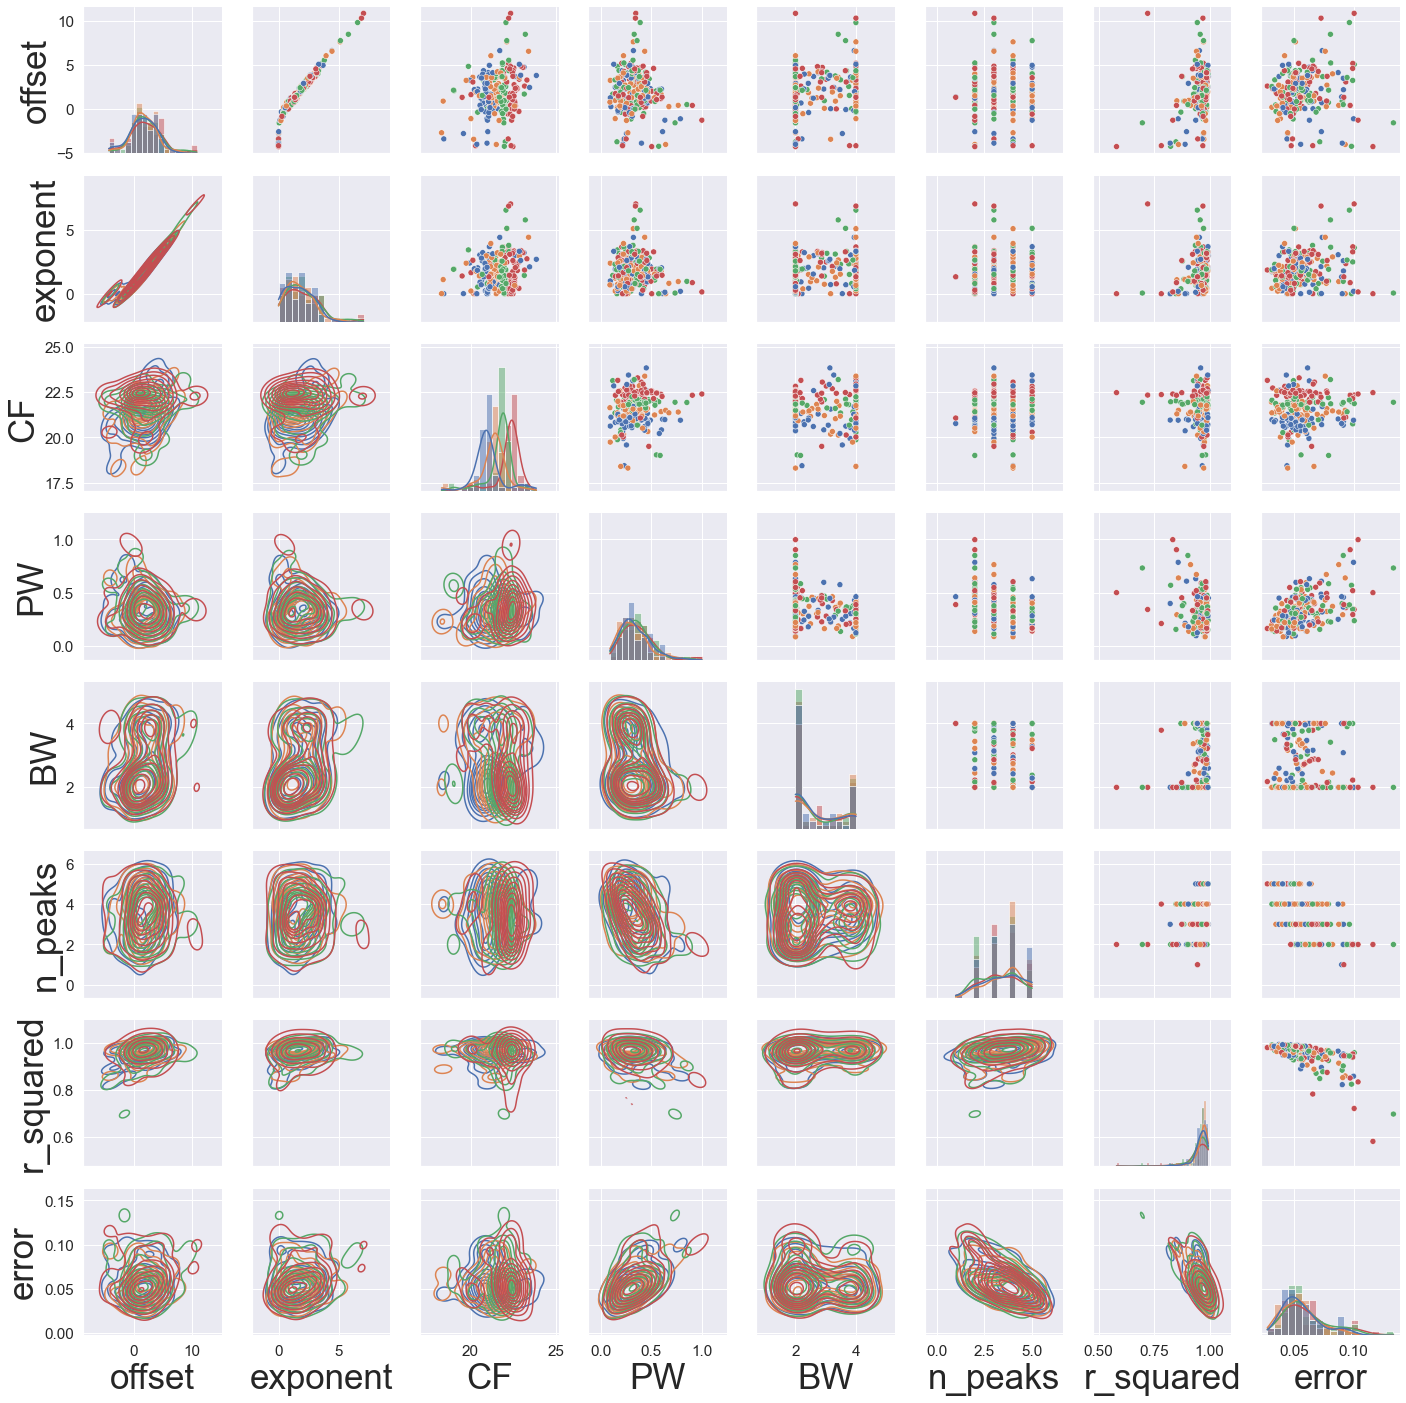

Done in 48.136s


In [12]:
tic = time.time()

plt.rcParams["axes.labelsize"] = 35
g = sns.PairGrid(df_num)
g.map_upper(sns.scatterplot, hue=df['target'])
g.map_lower(sns.kdeplot, hue=df['target'], cmap = "Blues_d")
g.map_diag(sns.histplot, hue=df['target'], kde=True)
plt.show()

toc = time.time()
print(f"Done in {toc - tic:.3f}s")

## 4. Correlation matrix

,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
offset,1.00,0.26,0.96,0.24,-0.10,0.24,0.05,0.27,0.07
knee,0.26,1.00,0.29,0.06,0.00,-0.04,-0.10,-0.32,0.16
exponent,0.96,0.29,1.00,0.22,-0.07,0.26,0.01,0.18,0.14
CF,0.24,0.06,0.22,1.00,0.10,-0.07,-0.01,-0.10,0.04
PW,-0.10,0.00,-0.07,0.10,1.00,-0.24,-0.39,-0.26,0.52
BW,0.24,-0.04,0.26,-0.07,-0.24,1.00,-0.02,0.13,-0.06
n_peaks,0.05,-0.10,0.01,-0.01,-0.39,-0.02,1.00,0.30,-0.58
r_squared,0.27,-0.32,0.18,-0.10,-0.26,0.13,0.30,1.00,-0.66
error,0.07,0.16,0.14,0.04,0.52,-0.06,-0.58,-0.66,1.00


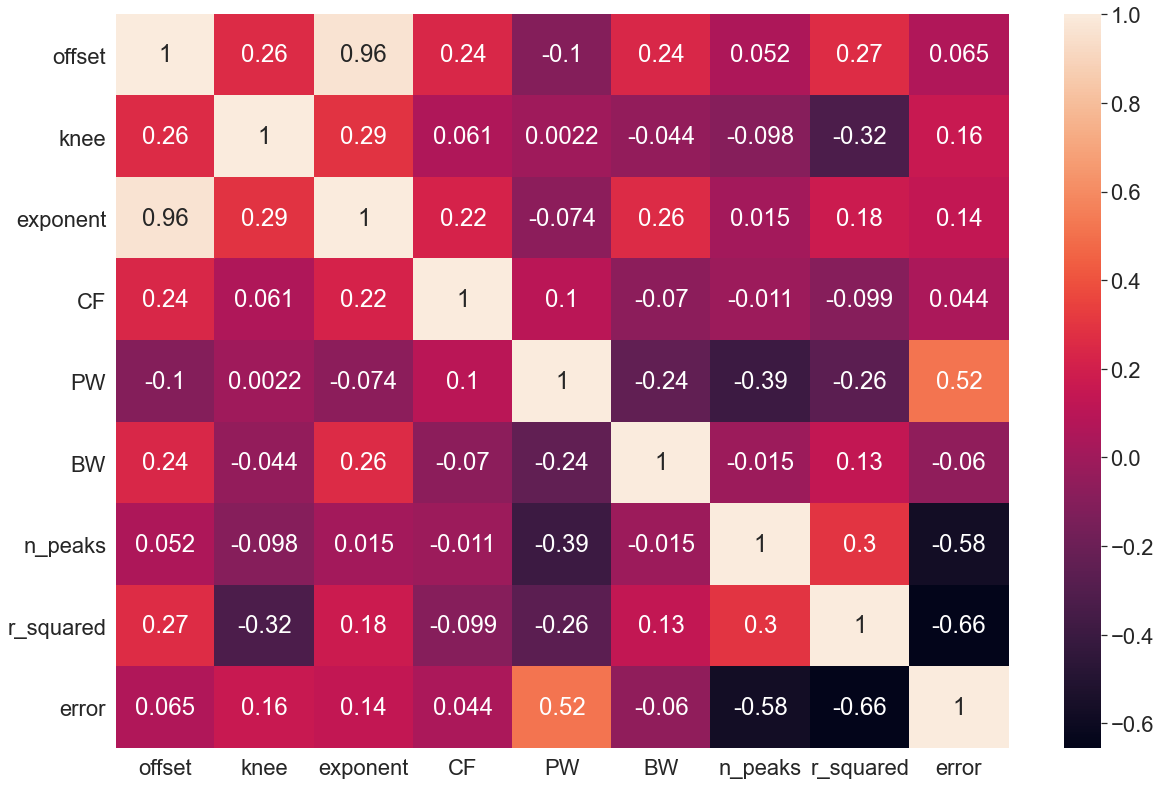

In [13]:
display(df.corr().round(2))

sns.set(font_scale = 2)
fig, heat = plt.subplots(figsize=(20,13.5))
heat = sns.heatmap(df.corr(), annot=True)
plt.show()

# IV. Classification
## Assign variables

In [14]:
# Number of observations
n_obs = len(df)

# Assign target and serie
y = df['target'].to_numpy().ravel()

# Select features
X = df.drop(columns=['subject', 'day', 'target']).to_numpy()

# Initialize dataframe
performance = pd.DataFrame([], index = [], columns = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table'])

## 1. Logistic regression

C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature: 0, Score: 0.56658
Feature: 1, Score: -202.86815
Feature: 2, Score: -0.21453
Feature: 3, Score: -0.97991
Feature: 4, Score: 0.12179
Feature: 5, Score: -0.00748
Feature: 6, Score: 0.01305
Feature: 7, Score: -0.45018
Feature: 8, Score: -0.31978


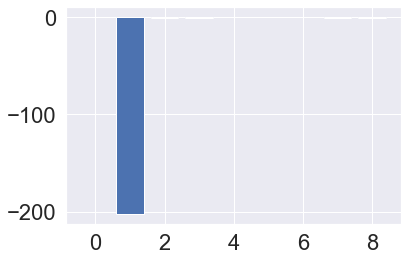

              precision    recall  f1-score   support

         210       0.67      0.50      0.57        16
         215       0.33      0.50      0.40         8
         220       0.58      0.47      0.52        15
         225       0.36      0.50      0.42         8

    accuracy                           0.49        47
   macro avg       0.49      0.49      0.48        47
weighted avg       0.53      0.49      0.50        47

Feature: 0, Score: 0.56541
Feature: 1, Score: -106.95551
Feature: 2, Score: -0.35760
Feature: 3, Score: -0.73145
Feature: 4, Score: 0.10686
Feature: 5, Score: -0.05451
Feature: 6, Score: 0.01455
Feature: 7, Score: -0.11848
Feature: 8, Score: -0.17063


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


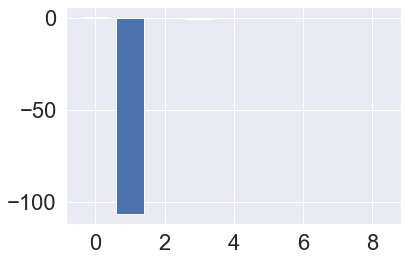

              precision    recall  f1-score   support

         210       0.58      0.88      0.70         8
         215       0.27      0.33      0.30         9
         220       0.42      0.42      0.42        12
         225       0.92      0.61      0.73        18

    accuracy                           0.55        47
   macro avg       0.55      0.56      0.54        47
weighted avg       0.61      0.55      0.56        47

Feature: 0, Score: 0.41803
Feature: 1, Score: -1.27235
Feature: 2, Score: -0.45097
Feature: 3, Score: -0.95142
Feature: 4, Score: -0.08084
Feature: 5, Score: -0.22685
Feature: 6, Score: 0.08828
Feature: 7, Score: -0.01617
Feature: 8, Score: 0.06029


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


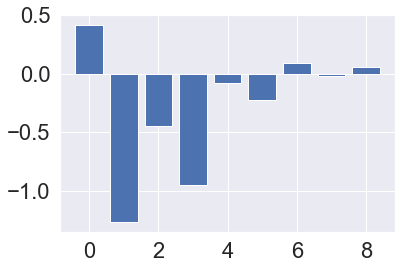

              precision    recall  f1-score   support

         210       0.50      0.50      0.50        12
         215       0.09      0.09      0.09        11
         220       0.17      0.22      0.19         9
         225       0.58      0.47      0.52        15

    accuracy                           0.34        47
   macro avg       0.34      0.32      0.32        47
weighted avg       0.37      0.34      0.35        47

Feature: 0, Score: 0.67223
Feature: 1, Score: -11.26097
Feature: 2, Score: -0.41353
Feature: 3, Score: -0.86233
Feature: 4, Score: 0.12361
Feature: 5, Score: -0.14790
Feature: 6, Score: 0.03572
Feature: 7, Score: -0.45973
Feature: 8, Score: -0.52898


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


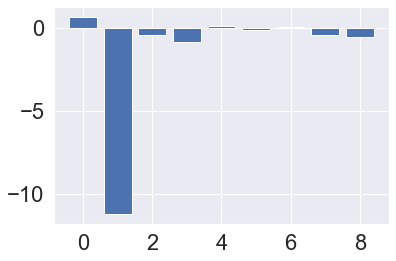

              precision    recall  f1-score   support

         210       0.50      0.35      0.41        17
         215       0.18      0.67      0.29         3
         220       0.33      0.29      0.31        14
         225       0.73      0.67      0.70        12

    accuracy                           0.43        46
   macro avg       0.44      0.49      0.43        46
weighted avg       0.49      0.43      0.45        46

Feature: 0, Score: 0.09382
Feature: 1, Score: -2.64346
Feature: 2, Score: 0.06524
Feature: 3, Score: -0.97651
Feature: 4, Score: 0.06726
Feature: 5, Score: -0.13676
Feature: 6, Score: -0.09376
Feature: 7, Score: -0.16800
Feature: 8, Score: -0.35199


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


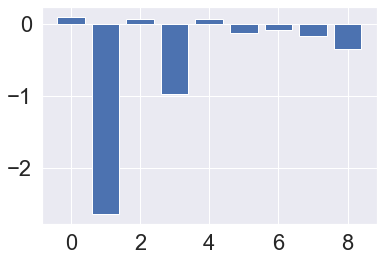

              precision    recall  f1-score   support

         210       0.55      0.50      0.52        12
         215       0.42      0.56      0.48         9
         220       0.50      0.60      0.55        10
         225       0.73      0.53      0.62        15

    accuracy                           0.54        46
   macro avg       0.55      0.55      0.54        46
weighted avg       0.57      0.54      0.55        46



In [15]:
# Split in K folds and standardize
K = 5
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Initialize model
    LR = LogisticRegression(penalty='none', random_state=13)

    # Fit model 
    LR.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = LR.predict(X_test_scaled)
    
    # Summarize feature importance
    importance = LR.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(classification_report(y_pred, y_test))

    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
    
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'log', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True) 

In [16]:
# Variance inflation factors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pd.DataFrame([variance_inflation_factor(X_scaled, i) for i in range(9)], 
             columns=['VIF'], \
             index = ['offset', 'knee', 'exponent', 'center of frequency', 'power', 'bandwidth', \
                      'n peaks', 'R2', 'MAE']).round(1)

,VIF
offset,17.7
knee,1.4
exponent,16.9
center of frequency,1.2
power,1.6
bandwidth,1.2
n peaks,1.6
R2,3.2
MAE,3.9


## 2. Ridge classifier

Feature: 0, Score: 0.02156
Feature: 1, Score: -0.02685
Feature: 2, Score: -0.00039
Feature: 3, Score: -0.24531
Feature: 4, Score: 0.02050
Feature: 5, Score: 0.00823
Feature: 6, Score: 0.02084
Feature: 7, Score: -0.02780
Feature: 8, Score: -0.01402


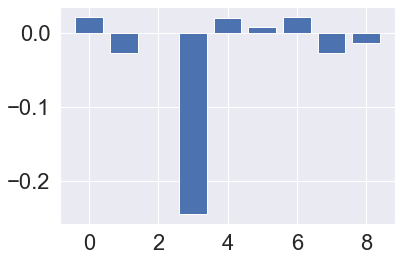

Alpha: 50.0
              precision    recall  f1-score   support

         210       0.58      0.41      0.48        17
         215       0.08      0.20      0.12         5
         220       0.33      0.36      0.35        11
         225       0.45      0.36      0.40        14

    accuracy                           0.36        47
   macro avg       0.36      0.33      0.34        47
weighted avg       0.43      0.36      0.39        47

Feature: 0, Score: 0.02576
Feature: 1, Score: -0.01831
Feature: 2, Score: -0.00717
Feature: 3, Score: -0.18941
Feature: 4, Score: 0.02106
Feature: 5, Score: -0.02409
Feature: 6, Score: 0.00822
Feature: 7, Score: 0.01538
Feature: 8, Score: -0.02365


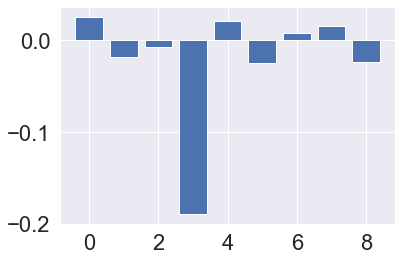

Alpha: 50.0
              precision    recall  f1-score   support

         210       0.67      0.67      0.67        12
         215       0.27      0.38      0.32         8
         220       0.25      0.50      0.33         6
         225       1.00      0.57      0.73        21

    accuracy                           0.55        47
   macro avg       0.55      0.53      0.51        47
weighted avg       0.70      0.55      0.59        47

Feature: 0, Score: -0.00524
Feature: 1, Score: -0.00774
Feature: 2, Score: -0.03050
Feature: 3, Score: -0.23909
Feature: 4, Score: -0.02505
Feature: 5, Score: -0.06445
Feature: 6, Score: 0.03075
Feature: 7, Score: 0.02396
Feature: 8, Score: 0.02073


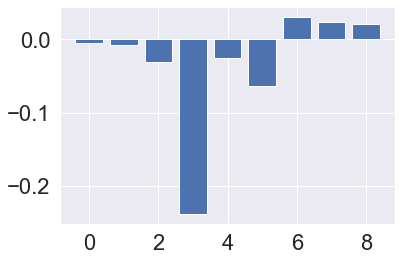

Alpha: 50.0
              precision    recall  f1-score   support

         210       0.50      0.46      0.48        13
         215       0.00      0.00      0.00         9
         220       0.08      0.17      0.11         6
         225       0.58      0.37      0.45        19

    accuracy                           0.30        47
   macro avg       0.29      0.25      0.26        47
weighted avg       0.38      0.30      0.33        47

Feature: 0, Score: 0.23372
Feature: 1, Score: -0.06150
Feature: 2, Score: -0.12831
Feature: 3, Score: -0.31053
Feature: 4, Score: 0.04493
Feature: 5, Score: -0.06648
Feature: 6, Score: 0.02029
Feature: 7, Score: -0.16442
Feature: 8, Score: -0.20456


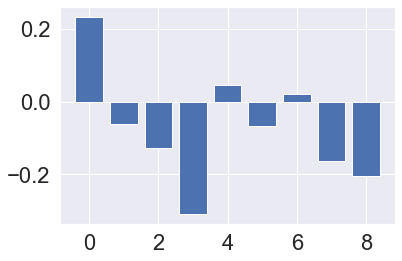

Alpha: 0.10772173450159434
              precision    recall  f1-score   support

         210       0.50      0.32      0.39        19
         215       0.00      0.00      0.00         1
         220       0.17      0.20      0.18        10
         225       0.82      0.56      0.67        16

    accuracy                           0.37        46
   macro avg       0.37      0.27      0.31        46
weighted avg       0.53      0.37      0.43        46

Feature: 0, Score: -0.00935
Feature: 1, Score: -0.00915
Feature: 2, Score: 0.00577
Feature: 3, Score: -0.24291
Feature: 4, Score: 0.00100
Feature: 5, Score: -0.03867
Feature: 6, Score: -0.01785
Feature: 7, Score: 0.01579
Feature: 8, Score: -0.05384


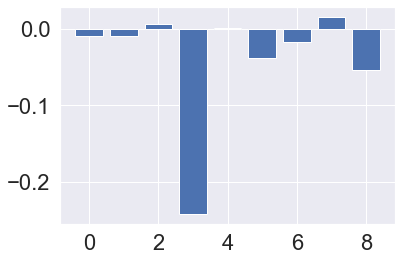

Alpha: 50.0
              precision    recall  f1-score   support

         210       0.64      0.47      0.54        15
         215       0.42      0.71      0.53         7
         220       0.17      0.50      0.25         4
         225       0.82      0.45      0.58        20

    accuracy                           0.50        46
   macro avg       0.51      0.53      0.47        46
weighted avg       0.64      0.50      0.53        46



In [17]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize Ridge hyperparameter λ 
    hyperparameters = {"alpha": 10**np.linspace(10,-2,10)*0.5} 
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RidgeClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    RC = RidgeClassifier(alpha=Grid.best_params_['alpha'], random_state=13)

    # Fit model 
    RC.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = RC.predict(X_test_scaled)

    # Summarize feature importance
    importance = RC.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print("Alpha:",Grid.best_params_['alpha'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
         
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'ridge', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 3. K-nearest neighbors

Feature: 0, Score: 0.00000
Feature: 1, Score: -0.01277
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


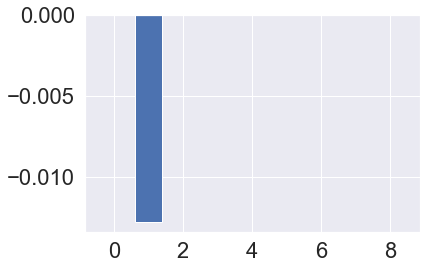

n_neighbors: 18
              precision    recall  f1-score   support

         210       0.67      0.42      0.52        19
         215       0.17      0.18      0.17        11
         220       0.17      0.25      0.20         8
         225       0.36      0.44      0.40         9

    accuracy                           0.34        47
   macro avg       0.34      0.32      0.32        47
weighted avg       0.41      0.34      0.36        47

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: -0.01702
Feature: 5, Score: -0.00426
Feature: 6, Score: -0.01277
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


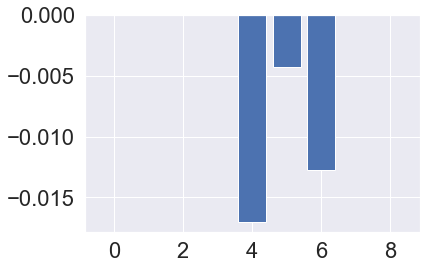

n_neighbors: 16
              precision    recall  f1-score   support

         210       0.67      0.62      0.64        13
         215       0.27      0.38      0.32         8
         220       0.25      0.23      0.24        13
         225       0.58      0.54      0.56        13

    accuracy                           0.45        47
   macro avg       0.44      0.44      0.44        47
weighted avg       0.46      0.45      0.45        47

Feature: 0, Score: 0.00851
Feature: 1, Score: -0.04255
Feature: 2, Score: 0.00851
Feature: 3, Score: 0.00851
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00426
Feature: 6, Score: -0.01702
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


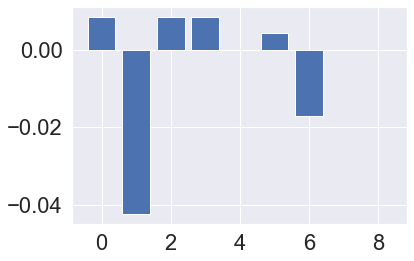

n_neighbors: 5
              precision    recall  f1-score   support

         210       0.33      0.27      0.30        15
         215       0.18      0.15      0.17        13
         220       0.17      0.22      0.19         9
         225       0.33      0.40      0.36        10

    accuracy                           0.26        47
   macro avg       0.25      0.26      0.25        47
weighted avg       0.26      0.26      0.25        47

Feature: 0, Score: 0.00000
Feature: 1, Score: -0.02174
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


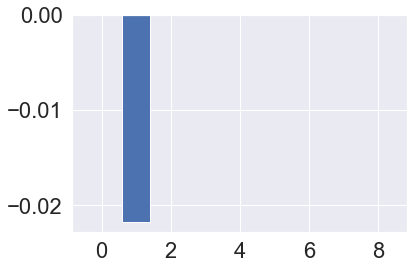

n_neighbors: 16
              precision    recall  f1-score   support

         210       0.50      0.46      0.48        13
         215       0.45      0.38      0.42        13
         220       0.33      0.31      0.32        13
         225       0.36      0.57      0.44         7

    accuracy                           0.41        46
   macro avg       0.41      0.43      0.42        46
weighted avg       0.42      0.41      0.41        46

Feature: 0, Score: -0.01739
Feature: 1, Score: -0.04348
Feature: 2, Score: -0.00435
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: -0.00870
Feature: 6, Score: -0.01304
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


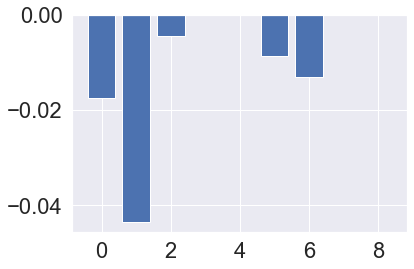

n_neighbors: 6
              precision    recall  f1-score   support

         210       0.55      0.29      0.37        21
         215       0.17      0.17      0.17        12
         220       0.17      0.33      0.22         6
         225       0.36      0.57      0.44         7

    accuracy                           0.30        46
   macro avg       0.31      0.34      0.30        46
weighted avg       0.37      0.30      0.31        46



In [18]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize hyperparameter K
    hyperparameters = {'n_neighbors':[i for i in range(1,20)]}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(KNeighborsClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
        
    # Initialize model
    KNN = KNeighborsClassifier(n_neighbors=Grid.best_params_['n_neighbors'])
    
    # Fit model 
    KNN.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = KNN.predict(X_test_scaled)
    
    # Summarize feature importance
    results = permutation_importance(KNN, X_test, y_test, scoring='accuracy')
    importance = results.importances_mean
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print('n_neighbors:',Grid.best_params_['n_neighbors'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'KNN', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 4. Multi-layer perceptron

In [19]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Optimize hyperparameters
    hyperparameters = {'activation':['identity', 'logistic', 'tanh', 'relu'], 'solver':['lbfgs', 'sgd', 'adam']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(MLPClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    MLP = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=500, activation = Grid.best_params_['activation'], \
                        solver=Grid.best_params_['solver'], random_state=13)

    # Fit model 
    MLP.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = MLP.predict(X_test_scaled)

    # Output
    print(f"\033[1mActivation function: \033[0m{Grid.best_params_['activation']}")
    print(f"\033[1mSolver: \033[0m{Grid.best_params_['solver']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
     
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'MLP', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.75      0.53      0.62        17
         215       0.42      0.45      0.43        11
         220       0.25      0.60      0.35         5
         225       0.73      0.57      0.64        14

    accuracy                           0.53        47
   macro avg       0.54      0.54      0.51        47
weighted avg       0.61      0.53      0.55        47

Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.67      0.73      0.70        11
         215       0.27      0.38      0.32         8
         220       0.58      0.37      0.45        19
         225       0.50      0.67      0.57         9

    accuracy                           0.51        47
   macro avg       0.51      0.53      0.51        47
weighted avg       0.53      0.51      0.51        47

Activation function: logistic
Solver: lbfg

## 5. Random forest

Feature: 0, Score: 0.07212
Feature: 1, Score: 0.08578
Feature: 2, Score: 0.07615
Feature: 3, Score: 0.42400
Feature: 4, Score: 0.09093
Feature: 5, Score: 0.06060
Feature: 6, Score: 0.02598
Feature: 7, Score: 0.08086
Feature: 8, Score: 0.08358


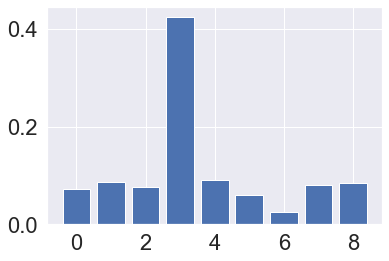

Number of trees: 200
Maximum depth: 32
Maximum features per node split: auto
              precision    recall  f1-score   support

         210       0.75      0.56      0.64        16
         215       0.50      0.75      0.60         8
         220       0.50      0.67      0.57         9
         225       0.82      0.64      0.72        14

    accuracy                           0.64        47
   macro avg       0.64      0.66      0.63        47
weighted avg       0.68      0.64      0.64        47

Feature: 0, Score: 0.06965
Feature: 1, Score: 0.08039
Feature: 2, Score: 0.07147
Feature: 3, Score: 0.43857
Feature: 4, Score: 0.08544
Feature: 5, Score: 0.05758
Feature: 6, Score: 0.02311
Feature: 7, Score: 0.08771
Feature: 8, Score: 0.08609


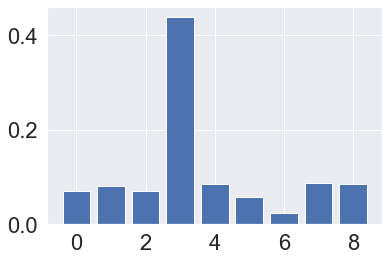

Number of trees: 1000
Maximum depth: 77
Maximum features per node split: auto
              precision    recall  f1-score   support

         210       0.75      0.82      0.78        11
         215       0.45      0.56      0.50         9
         220       0.67      0.50      0.57        16
         225       0.67      0.73      0.70        11

    accuracy                           0.64        47
   macro avg       0.63      0.65      0.64        47
weighted avg       0.65      0.64      0.64        47

Feature: 0, Score: 0.06888
Feature: 1, Score: 0.08607
Feature: 2, Score: 0.08050
Feature: 3, Score: 0.42034
Feature: 4, Score: 0.08865
Feature: 5, Score: 0.06291
Feature: 6, Score: 0.02762
Feature: 7, Score: 0.07922
Feature: 8, Score: 0.08581


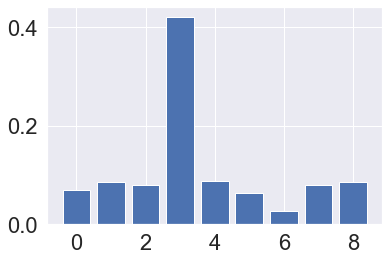

Number of trees: 200
Maximum depth: 10
Maximum features per node split: auto
              precision    recall  f1-score   support

         210       0.67      0.67      0.67        12
         215       0.55      0.55      0.55        11
         220       0.67      0.67      0.67        12
         225       0.67      0.67      0.67        12

    accuracy                           0.64        47
   macro avg       0.64      0.64      0.64        47
weighted avg       0.64      0.64      0.64        47

Feature: 0, Score: 0.07525
Feature: 1, Score: 0.08147
Feature: 2, Score: 0.07915
Feature: 3, Score: 0.43013
Feature: 4, Score: 0.08026
Feature: 5, Score: 0.06007
Feature: 6, Score: 0.02529
Feature: 7, Score: 0.08494
Feature: 8, Score: 0.08344


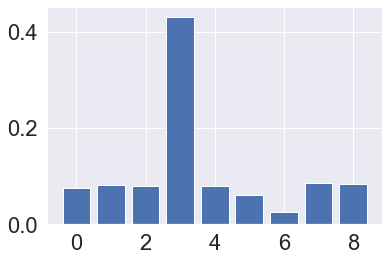

Number of trees: 200
Maximum depth: 32
Maximum features per node split: sqrt
              precision    recall  f1-score   support

         210       0.50      0.60      0.55        10
         215       0.55      0.43      0.48        14
         220       0.75      0.69      0.72        13
         225       0.64      0.78      0.70         9

    accuracy                           0.61        46
   macro avg       0.61      0.62      0.61        46
weighted avg       0.61      0.61      0.61        46

Feature: 0, Score: 0.07544
Feature: 1, Score: 0.07975
Feature: 2, Score: 0.07515
Feature: 3, Score: 0.42344
Feature: 4, Score: 0.07955
Feature: 5, Score: 0.06276
Feature: 6, Score: 0.02584
Feature: 7, Score: 0.08761
Feature: 8, Score: 0.09046


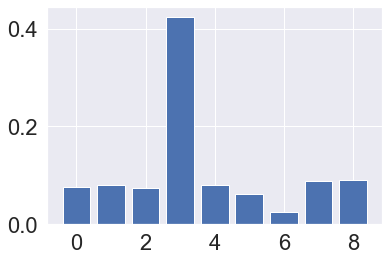

Number of trees: 2000
Maximum depth: 100
Maximum features per node split: auto
              precision    recall  f1-score   support

         210       0.64      0.44      0.52        16
         215       0.33      0.50      0.40         8
         220       0.58      0.78      0.67         9
         225       0.82      0.69      0.75        13

    accuracy                           0.59        46
   macro avg       0.59      0.60      0.58        46
weighted avg       0.62      0.59      0.59        46

Done in 675.9501848220825 seconds


In [20]:
tic = time.time()

# Split in K folds
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    # Optimize hyperparameters
    hyperparameters = {"n_estimators": [200, 1000, 2000], \
                       "max_depth": [int(x) for x in np.linspace(10, 100, num = 5)],\
                       "max_features": ['auto', 'sqrt']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RandomForestClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train, y_train)
    
    # Initiating a RF classifier
    RFC = RandomForestClassifier(n_estimators = Grid.best_params_['n_estimators'], \
                                max_depth = Grid.best_params_['max_depth'], \
                                max_features = Grid.best_params_['max_features'], random_state = 13)  

    # Fit model
    RFC.fit(X_train, y_train)
  
    # performing predictions on the test dataset
    y_pred = RFC.predict(X_test)
    
    # Summarize feature importance
    importance = RFC.feature_importances_
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(f"\033[1mNumber of trees: \033[0m{Grid.best_params_['n_estimators']}")
    print(f"\033[1mMaximum depth: \033[0m{Grid.best_params_['max_depth']}")
    print(f"\033[1mMaximum features per node split: \033[0m{Grid.best_params_['max_features']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'RF',  n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)    

print(f'Done in {time.time()-tic} seconds')

# Same for 3 channels
# I. Preparation

In [21]:
# Occipital channels
channels = (23,24,25) 
n_channels = 3

# II. Fourier transform and FOOOF

In [22]:
## Read EEG, calculate PSD (Welch), fit FOOOF

tic = time.time()
for subject in subjects: 
    for day in days:
        # Initialize per target, average over trials and channels
        powers_50 = np.empty((0, int(nperseg//2)+1), float)
        powers_55 = np.empty((0, int(nperseg//2)+1), float)
        powers_60 = np.empty((0, int(nperseg//2)+1), float)
        powers_65 = np.empty((0, int(nperseg//2)+1), float)
        powers_210 = np.empty((0, int(nperseg//2)+1), float)
        powers_215 = np.empty((0, int(nperseg//2)+1), float)
        powers_220 = np.empty((0, int(nperseg//2)+1), float)
        powers_225 = np.empty((0, int(nperseg//2)+1), float)
        powers_400 = np.empty((0, int(nperseg//2)+1), float)
        powers_405 = np.empty((0, int(nperseg//2)+1), float)
        powers_410 = np.empty((0, int(nperseg//2)+1), float)
        powers_415 = np.empty((0, int(nperseg//2)+1), float)

        # Change working directory
        original = os.getcwd()
        os.chdir("C:/Users/ThinkPad/Desktop/Thesis/Data/"+subject+day)

        # Giving directory name
        folderdir = 'C:/Users/ThinkPad/Desktop/Thesis/Data/'+subject+day

        # Giving file extensions
        ext = ('.mat')

        # Iterating over directory
        for path, dirc, files in os.walk(folderdir):
            for file in files:
                if file.endswith(ext) and file.startswith('cnt'):
                    print(subject, day, file)

                    # LOW, MID, or HIGH
                    level = file[4:-7]

                    # Session 1, or session 2
                    session = file[-6]

                    # Read data
                    data = read_matlab(file)['cnt']['x']

                    # Read timestamps 
                    timestamps = (read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['time'])[0]

                    # Read stimuli order
                    order_stimuli = read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['event']['desc']

                    for trial, timestamp in enumerate(timestamps):   
                        if trial%2 == False:
                            start = int(timestamp)
                        else:
                            stop = int(timestamp)

                            for channel in channels:
#                                 # Apply bandpass filter
#                                 data[:,channel] = filter_signal(data[:,channel], fs, 'bandpass', f_range=fr)
                                # Splice data according to timestamps
                                sig = data[:,channel][start:stop]
                                times = create_times(len(sig)/fs, fs)

                                # Plot EEG 
#                                 fig, ax = plt.subplots(figsize=[15, 5])
#                                 plot_time_series(times, sig, xlim=[0,len(sig)/fs], ax=ax)
#                                 plt.show()                                

                                # Welch FFT: calculate mean of spectrogram
                                freq, power = signal.welch(sig, fs, window='hann', average='mean', nperseg=nperseg,\
                                                          noverlap=450, detrend='constant')

                                # Append power to previous powers
                                if level=='LOW':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_50 = np.append(powers_50, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_55 = np.append(powers_55, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_60 = np.append(powers_60, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_65 = np.append(powers_65, power.reshape(1, len(freq)), axis=0)
                                elif level=='MID':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_210 = np.append(powers_210, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_215 = np.append(powers_215, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_220 = np.append(powers_220, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_225 = np.append(powers_225, power.reshape(1, len(freq)), axis=0)
                                elif level=='HIGH':
                                    if order_stimuli[trial-1]==[1.]: 
                                        powers_400 = np.append(powers_400, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        powers_405 = np.append(powers_405, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        powers_410 = np.append(powers_410, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        powers_415 = np.append(powers_415, power.reshape(1, len(freq)), axis=0)
                                        
        # Fit FOOOF model per target
        for (powers, target) in zip((powers_210, powers_215, powers_220, powers_225), \
                                    (210, 215, 220, 225)):
            # FOOOF object: initialize, fit and print results
            fm = FOOOF(aperiodic_mode='knee', peak_width_limits=pwl, max_n_peaks=mnp, peak_threshold=pt, verbose=True)
            fm.fit(freq, np.mean(powers, axis=0), freq_range=fr)
            fm.print_results()
#             fig, ax = plt.subplots(figsize=[15, 5])
#             fm.plot(plot_peaks='line-shade', ax=ax)
#             plt.show()

            # Save metadata, FOOOF parameters and results
            try:
                if np.isnan(get_band_peak_fm(fm, band=bn, select_highest=True)[0])==False:
                    row = pd.DataFrame([subject, day, target, \
                                        fm.aperiodic_params_[0], \
                                        fm.aperiodic_params_[1], \
                                        fm.aperiodic_params_[2], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[0], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[1], \
                                        get_band_peak_fm(fm, band=bn, select_highest=True)[2], \
                                        fm.n_peaks_,\
                                        fm.r_squared_, \
                                        fm.error_],
                                       index = ['subject', 'day', 'target', \
                                                'offset', 'knee', 'exponent',\
                                                'CF', 'PW', 'BW', 'n_peaks', \
                                                'r_squared', 'error']).transpose()
                    df = df.append(row, ignore_index=True) 
            except:
                pass

# Typecast dataframe
df[['subject', 'day', 'target']] = df[['subject', 'day', 'target']].astype('category')
df['n_peaks'] = df['n_peaks'].astype('int32')
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']] = \
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']].astype('float32')

# Change working directory back
os.chdir(original)

print(f'Done in {time.time()-tic} seconds')

S1 /Day1 cnt_HIGH(1).mat
S1 /Day1 cnt_HIGH(2).mat
S1 /Day1 cnt_LOW(1).mat
S1 /Day1 cnt_LOW(2).mat
S1 /Day1 cnt_MID(1).mat
S1 /Day1 cnt_MID(2).mat
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 10 - 50 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -3.4291, -1.0021, 0.0009                                     
                                                              

# IV. Classification
## Assign variables

In [23]:
# Number of observations
n_obs = len(df)

# Assign target and serie
y = df['target'].to_numpy().ravel()

# Select features
X = df.drop(columns=['subject', 'day', 'target']).to_numpy()

## 1. Logistic regression

Feature: 0, Score: -0.02898
Feature: 1, Score: 0.86958
Feature: 2, Score: 0.18916
Feature: 3, Score: -1.09625
Feature: 4, Score: 0.13704
Feature: 5, Score: -0.04540
Feature: 6, Score: -0.02839
Feature: 7, Score: -0.13310
Feature: 8, Score: -0.24445


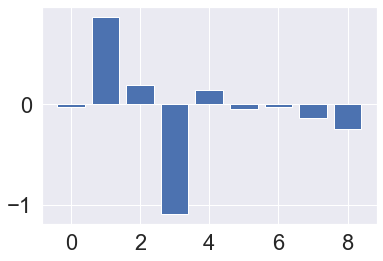

              precision    recall  f1-score   support

         210       0.75      0.64      0.69        28
         215       0.35      0.35      0.35        23
         220       0.29      0.41      0.34        17
         225       0.78      0.69      0.73        26

    accuracy                           0.54        94
   macro avg       0.54      0.52      0.53        94
weighted avg       0.58      0.54      0.56        94

Feature: 0, Score: -0.01352
Feature: 1, Score: -0.66422
Feature: 2, Score: 0.10734
Feature: 3, Score: -1.13156
Feature: 4, Score: 0.20359
Feature: 5, Score: -0.20257
Feature: 6, Score: 0.04995
Feature: 7, Score: -0.02651
Feature: 8, Score: -0.19872


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


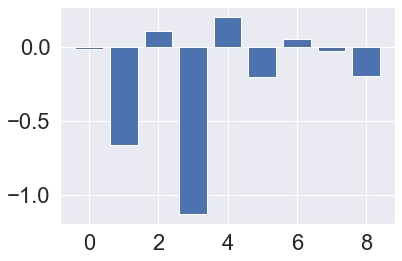

              precision    recall  f1-score   support

         210       0.62      0.60      0.61        25
         215       0.35      0.50      0.41        16
         220       0.33      0.40      0.36        20
         225       0.87      0.61      0.71        33

    accuracy                           0.54        94
   macro avg       0.54      0.53      0.53        94
weighted avg       0.60      0.54      0.56        94

Feature: 0, Score: 0.54705
Feature: 1, Score: -1.98001
Feature: 2, Score: -0.30746
Feature: 3, Score: -1.03965
Feature: 4, Score: 0.08300
Feature: 5, Score: -0.00917
Feature: 6, Score: -0.06812
Feature: 7, Score: -0.15559
Feature: 8, Score: -0.18590


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


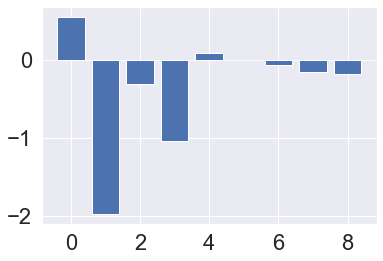

              precision    recall  f1-score   support

         210       0.46      0.46      0.46        24
         215       0.35      0.40      0.37        20
         220       0.54      0.54      0.54        24
         225       0.74      0.65      0.69        26

    accuracy                           0.52        94
   macro avg       0.52      0.51      0.52        94
weighted avg       0.53      0.52      0.53        94

Feature: 0, Score: 0.11101
Feature: 1, Score: -30.98668
Feature: 2, Score: -0.03214
Feature: 3, Score: -1.04429
Feature: 4, Score: 0.15425
Feature: 5, Score: -0.10790
Feature: 6, Score: -0.03878
Feature: 7, Score: -0.20385
Feature: 8, Score: -0.30556


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


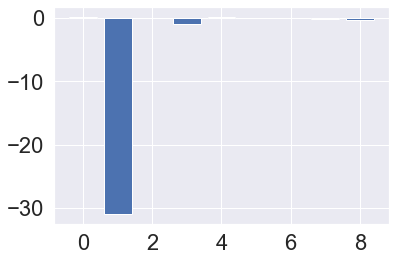

              precision    recall  f1-score   support

         210       0.52      0.57      0.55        21
         215       0.33      0.36      0.35        22
         220       0.42      0.43      0.43        23
         225       0.77      0.63      0.69        27

    accuracy                           0.51        93
   macro avg       0.51      0.50      0.50        93
weighted avg       0.52      0.51      0.51        93

Feature: 0, Score: 0.13132
Feature: 1, Score: -0.85658
Feature: 2, Score: -0.01502
Feature: 3, Score: -1.09338
Feature: 4, Score: 0.13047
Feature: 5, Score: -0.09790
Feature: 6, Score: -0.05328
Feature: 7, Score: -0.16391
Feature: 8, Score: -0.30547


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


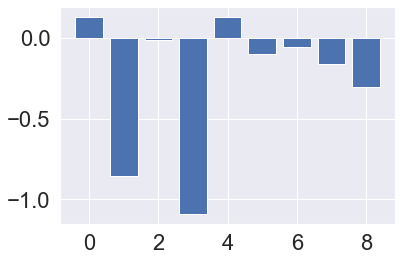

              precision    recall  f1-score   support

         210       0.74      0.61      0.67        28
         215       0.35      0.50      0.41        16
         220       0.29      0.41      0.34        17
         225       0.74      0.53      0.62        32

    accuracy                           0.53        93
   macro avg       0.53      0.51      0.51        93
weighted avg       0.59      0.53      0.55        93



In [24]:
# Split in K folds and standardize
K = 5
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Initialize model
    LR = LogisticRegression(penalty='none', random_state=13)

    # Fit model 
    LR.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = LR.predict(X_test_scaled)
    
    # Summarize feature importance
    importance = LR.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(classification_report(y_pred, y_test))

    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
    
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'log', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True) 

In [25]:
# Variance inflation factors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pd.DataFrame([variance_inflation_factor(X_scaled, i) for i in range(9)], 
             columns=['VIF'], \
             index = ['offset', 'knee', 'exponent', 'center of frequency', 'power', 'bandwidth', \
                      'n peaks', 'R2', 'MAE']).round(1)

,VIF
offset,13.4
knee,1.2
exponent,13.6
center of frequency,1.2
power,1.8
bandwidth,1.2
n peaks,1.5
R2,2.4
MAE,3.3


## 2. Ridge classifier

Feature: 0, Score: 0.00725
Feature: 1, Score: -0.01682
Feature: 2, Score: 0.03054
Feature: 3, Score: -0.29608
Feature: 4, Score: 0.02912
Feature: 5, Score: -0.02887
Feature: 6, Score: -0.00875
Feature: 7, Score: -0.01251
Feature: 8, Score: -0.04971


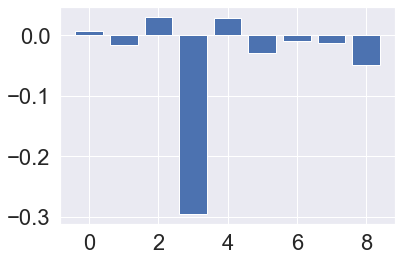

Alpha: 50.0
              precision    recall  f1-score   support

         210       0.75      0.55      0.63        33
         215       0.22      0.33      0.26        15
         220       0.25      0.35      0.29        17
         225       0.70      0.55      0.62        29

    accuracy                           0.48        94
   macro avg       0.48      0.45      0.45        94
weighted avg       0.56      0.48      0.51        94

Feature: 0, Score: -0.04565
Feature: 1, Score: -0.01441
Feature: 2, Score: 0.07317
Feature: 3, Score: -0.35970
Feature: 4, Score: 0.08560
Feature: 5, Score: -0.06424
Feature: 6, Score: 0.02384
Feature: 7, Score: -0.00282
Feature: 8, Score: -0.07351


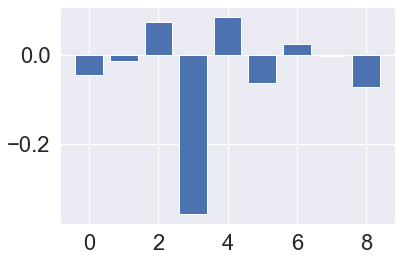

Alpha: 2.320794416806396
              precision    recall  f1-score   support

         210       0.71      0.52      0.60        33
         215       0.30      0.70      0.42        10
         220       0.21      0.38      0.27        13
         225       0.96      0.58      0.72        38

    accuracy                           0.54        94
   macro avg       0.54      0.54      0.50        94
weighted avg       0.70      0.54      0.58        94

Feature: 0, Score: 0.22203
Feature: 1, Score: -0.03834
Feature: 2, Score: -0.14257
Feature: 3, Score: -0.32882
Feature: 4, Score: 0.03647
Feature: 5, Score: -0.01749
Feature: 6, Score: -0.02862
Feature: 7, Score: -0.05524
Feature: 8, Score: -0.07422


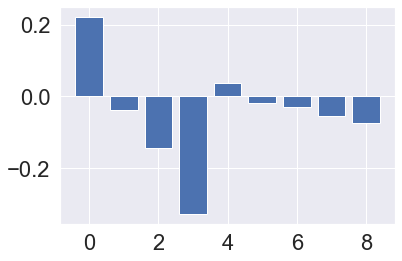

Alpha: 0.005
              precision    recall  f1-score   support

         210       0.62      0.47      0.54        32
         215       0.30      0.44      0.36        16
         220       0.08      0.40      0.14         5
         225       0.83      0.46      0.59        41

    accuracy                           0.46        94
   macro avg       0.46      0.44      0.41        94
weighted avg       0.63      0.46      0.51        94

Feature: 0, Score: -0.01272
Feature: 1, Score: -0.00890
Feature: 2, Score: -0.00885
Feature: 3, Score: -0.28795
Feature: 4, Score: 0.03298
Feature: 5, Score: -0.02886
Feature: 6, Score: -0.00982
Feature: 7, Score: -0.00903
Feature: 8, Score: -0.05265


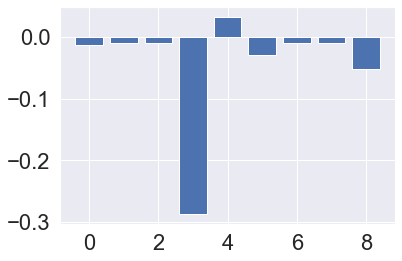

Alpha: 50.0
              precision    recall  f1-score   support

         210       0.70      0.50      0.58        32
         215       0.21      0.38      0.27        13
         220       0.17      0.36      0.23        11
         225       0.86      0.51      0.64        37

    accuracy                           0.47        93
   macro avg       0.48      0.44      0.43        93
weighted avg       0.63      0.47      0.52        93

Feature: 0, Score: 0.00498
Feature: 1, Score: -0.01170
Feature: 2, Score: -0.00168
Feature: 3, Score: -0.30576
Feature: 4, Score: 0.02411
Feature: 5, Score: -0.02684
Feature: 6, Score: -0.01402
Feature: 7, Score: -0.01011
Feature: 8, Score: -0.06363


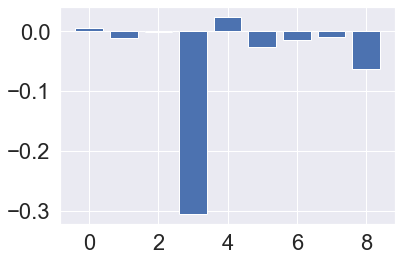

Alpha: 50.0
              precision    recall  f1-score   support

         210       0.78      0.55      0.64        33
         215       0.22      0.71      0.33         7
         220       0.21      0.38      0.27        13
         225       0.74      0.42      0.54        40

    accuracy                           0.48        93
   macro avg       0.49      0.52      0.45        93
weighted avg       0.64      0.48      0.52        93



In [26]:
# Initialize dataframe
importances = pd.DataFrame([], index = [], columns = ['offset', 'knee', 'exponent', 'frequency', 'power', 'bandwidth', \
                                                      'n peaks', 'MAE', 'R2'])

# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize Ridge hyperparameter λ 
    hyperparameters = {"alpha": 10**np.linspace(10,-2,10)*0.5} 
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RidgeClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    RC = RidgeClassifier(alpha=Grid.best_params_['alpha'], random_state=13)

    # Fit model 
    RC.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = RC.predict(X_test_scaled)

    # Summarize feature importance
    importance = RC.coef_[0]
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))   
    importances = importances.append(pd.DataFrame(importance, index = ['offset', 'knee', 'exponent', 'frequency', 'power', \
                                                                       'bandwidth', 'n peaks', 'MAE', 'R2']).transpose(), \
                                     ignore_index=False)
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print("Alpha:",Grid.best_params_['alpha'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
         
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'ridge', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

Text(0, 0.5, 'Coefficients')

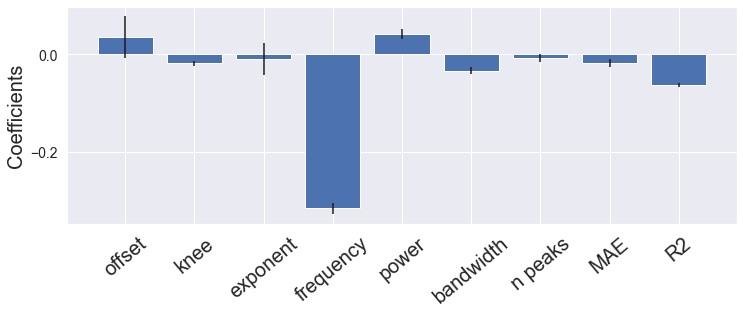

In [27]:
# Histograms importances features
tick = ['offset', 'knee', 'exponent', 'frequency', 'power', 'bandwidth', 'n peaks', 'MAE', 'R2']
Ridge_imp = np.mean(importances, axis=0)
Ridge_imp_std = np.std(importances, axis=0)/sqrt(5)

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize =(12, 4))
plt.bar(np.arange(len(Ridge_imp)),Ridge_imp, yerr=Ridge_imp_std, tick_label=tick)
plt.xticks(rotation=40, fontsize = 20)
plt.yticks(fontsize = 14)
ax.set_ylabel('Coefficients', fontsize = 20)

## 3. K-nearest neighbors

Feature: 0, Score: -0.03404
Feature: 1, Score: -0.00426
Feature: 2, Score: -0.04255
Feature: 3, Score: 0.00213
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00426
Feature: 6, Score: 0.01277
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


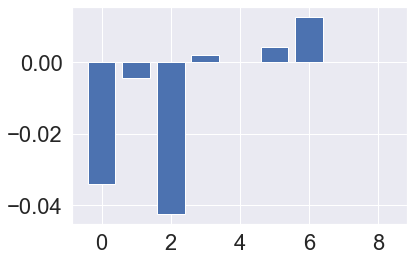

n_neighbors: 18
              precision    recall  f1-score   support

         210       0.71      0.49      0.58        35
         215       0.17      0.17      0.17        23
         220       0.42      0.42      0.42        24
         225       0.43      0.83      0.57        12

    accuracy                           0.44        94
   macro avg       0.43      0.48      0.43        94
weighted avg       0.47      0.44      0.44        94

Feature: 0, Score: 0.01915
Feature: 1, Score: 0.00851
Feature: 2, Score: 0.01277
Feature: 3, Score: 0.01489
Feature: 4, Score: 0.02979
Feature: 5, Score: 0.02979
Feature: 6, Score: 0.03404
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


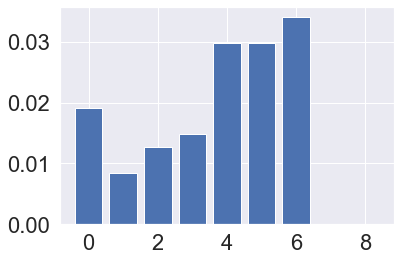

n_neighbors: 15
              precision    recall  f1-score   support

         210       0.58      0.52      0.55        27
         215       0.30      0.32      0.31        22
         220       0.38      0.35      0.36        26
         225       0.57      0.68      0.62        19

    accuracy                           0.46        94
   macro avg       0.46      0.47      0.46        94
weighted avg       0.46      0.46      0.46        94

Feature: 0, Score: -0.05319
Feature: 1, Score: 0.05319
Feature: 2, Score: -0.03617
Feature: 3, Score: -0.00851
Feature: 4, Score: -0.00851
Feature: 5, Score: 0.00000
Feature: 6, Score: -0.00851
Feature: 7, Score: -0.00213
Feature: 8, Score: -0.00426


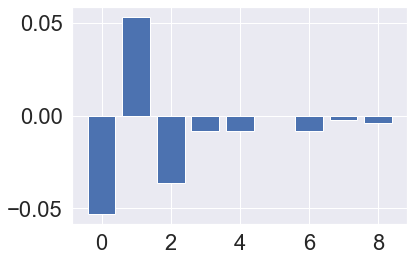

n_neighbors: 19
              precision    recall  f1-score   support

         210       0.62      0.58      0.60        26
         215       0.43      0.42      0.43        24
         220       0.29      0.37      0.33        19
         225       0.61      0.56      0.58        25

    accuracy                           0.49        94
   macro avg       0.49      0.48      0.48        94
weighted avg       0.50      0.49      0.50        94

Feature: 0, Score: 0.00000
Feature: 1, Score: -0.01075
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


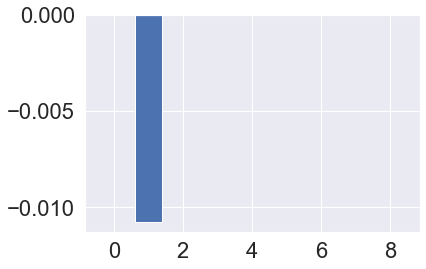

n_neighbors: 1
              precision    recall  f1-score   support

         210       0.26      0.38      0.31        16
         215       0.25      0.22      0.24        27
         220       0.54      0.39      0.46        33
         225       0.41      0.53      0.46        17

    accuracy                           0.37        93
   macro avg       0.37      0.38      0.37        93
weighted avg       0.38      0.37      0.37        93

Feature: 0, Score: -0.00645
Feature: 1, Score: -0.02366
Feature: 2, Score: -0.00860
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00215
Feature: 5, Score: -0.00215
Feature: 6, Score: 0.00215
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000


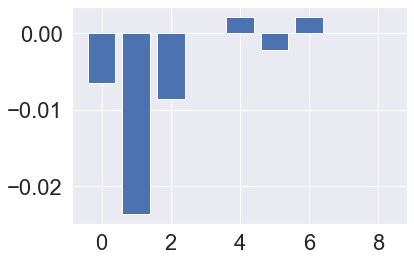

n_neighbors: 19
              precision    recall  f1-score   support

         210       0.57      0.52      0.54        25
         215       0.48      0.42      0.45        26
         220       0.25      0.40      0.31        15
         225       0.57      0.48      0.52        27

    accuracy                           0.46        93
   macro avg       0.46      0.46      0.45        93
weighted avg       0.49      0.46      0.47        93



In [28]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]
    
    # Optimize hyperparameter K
    hyperparameters = {'n_neighbors':[i for i in range(1,20)]}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(KNeighborsClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
        
    # Initialize model
    KNN = KNeighborsClassifier(n_neighbors=Grid.best_params_['n_neighbors'])
    
    # Fit model 
    KNN.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = KNN.predict(X_test_scaled)
    
    # Summarize feature importance
    results = permutation_importance(KNN, X_test, y_test, scoring='accuracy')
    importance = results.importances_mean
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()
    
    # Output
    print('n_neighbors:',Grid.best_params_['n_neighbors'])
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'KNN', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

## 4. Multi-layer perceptron

In [29]:
# Split in K folds and standardize
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    y_train, y_test = y[train_index], y[test_index]

    # Optimize hyperparameters
    hyperparameters = {'activation':['identity', 'logistic', 'tanh', 'relu'], 'solver':['lbfgs', 'sgd', 'adam']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(MLPClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train_scaled, y_train)
    
    # Initialize model
    MLP = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=500, activation = Grid.best_params_['activation'], \
                        solver=Grid.best_params_['solver'], random_state=13)

    # Fit model 
    MLP.fit(X_train_scaled,y_train)

    # Predict output
    y_pred = MLP.predict(X_test_scaled)

    # Output
    print(f"\033[1mActivation function: \033[0m{Grid.best_params_['activation']}")
    print(f"\033[1mSolver: \033[0m{Grid.best_params_['solver']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
     
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'MLP', n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)   

Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.50      0.63      0.56        19
         215       0.74      0.50      0.60        34
         220       0.58      0.74      0.65        19
         225       0.78      0.82      0.80        22

    accuracy                           0.65        94
   macro avg       0.65      0.67      0.65        94
weighted avg       0.67      0.65      0.65        94

Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.54      0.72      0.62        18
         215       0.61      0.48      0.54        29
         220       0.54      0.52      0.53        25
         225       0.65      0.68      0.67        22

    accuracy                           0.59        94
   macro avg       0.59      0.60      0.59        94
weighted avg       0.59      0.59      0.58        94



C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.79      0.79      0.79        24
         215       0.35      0.57      0.43        14
         220       0.75      0.62      0.68        29
         225       0.83      0.70      0.76        27

    accuracy                           0.68        94
   macro avg       0.68      0.67      0.67        94
weighted avg       0.72      0.68      0.69        94

Activation function: logistic
Solver: lbfgs
              precision    recall  f1-score   support

         210       0.52      0.57      0.55        21
         215       0.42      0.38      0.40        26
         220       0.62      0.58      0.60        26
         225       0.77      0.85      0.81        20

    accuracy                           0.58        93
   macro avg       0.58      0.60      0.59        93
weighted avg       0.58      0.58      0.58        93

Activation function: relu
Solver: lbfgs
  

## 5. Random forest

Feature: 0, Score: 0.06948
Feature: 1, Score: 0.07141
Feature: 2, Score: 0.07095
Feature: 3, Score: 0.47011
Feature: 4, Score: 0.08729
Feature: 5, Score: 0.06388
Feature: 6, Score: 0.02641
Feature: 7, Score: 0.06973
Feature: 8, Score: 0.07074


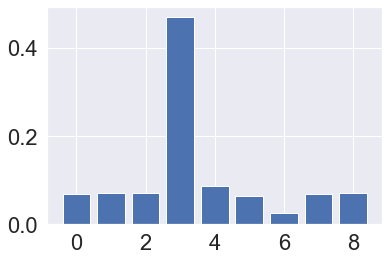

Number of trees: 2000
Maximum depth: 55
Maximum features per node split: sqrt
              precision    recall  f1-score   support

         210       0.79      0.76      0.78        25
         215       0.83      0.61      0.70        31
         220       0.71      0.89      0.79        19
         225       0.78      0.95      0.86        19

    accuracy                           0.78        94
   macro avg       0.78      0.80      0.78        94
weighted avg       0.78      0.78      0.77        94

Feature: 0, Score: 0.06359
Feature: 1, Score: 0.07295
Feature: 2, Score: 0.06639
Feature: 3, Score: 0.48760
Feature: 4, Score: 0.07691
Feature: 5, Score: 0.06801
Feature: 6, Score: 0.02169
Feature: 7, Score: 0.06977
Feature: 8, Score: 0.07311


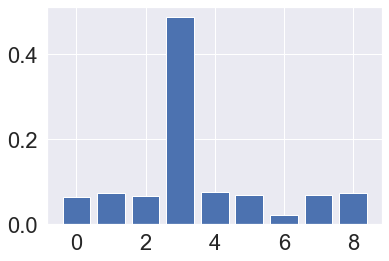

Number of trees: 200
Maximum depth: 10
Maximum features per node split: auto
              precision    recall  f1-score   support

         210       0.71      0.68      0.69        25
         215       0.52      0.63      0.57        19
         220       0.71      0.71      0.71        24
         225       0.87      0.77      0.82        26

    accuracy                           0.70        94
   macro avg       0.70      0.70      0.70        94
weighted avg       0.72      0.70      0.71        94

Feature: 0, Score: 0.07269
Feature: 1, Score: 0.07394
Feature: 2, Score: 0.07020
Feature: 3, Score: 0.48460
Feature: 4, Score: 0.08049
Feature: 5, Score: 0.06105
Feature: 6, Score: 0.02553
Feature: 7, Score: 0.06414
Feature: 8, Score: 0.06735


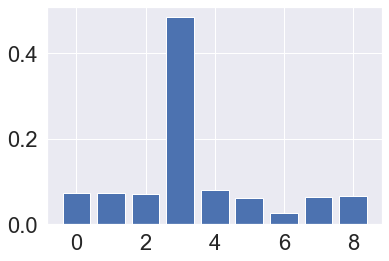

Number of trees: 200
Maximum depth: 10
Maximum features per node split: auto
              precision    recall  f1-score   support

         210       0.92      0.69      0.79        32
         215       0.43      0.71      0.54        14
         220       0.92      0.79      0.85        28
         225       0.74      0.85      0.79        20

    accuracy                           0.76        94
   macro avg       0.75      0.76      0.74        94
weighted avg       0.81      0.76      0.77        94

Feature: 0, Score: 0.06967
Feature: 1, Score: 0.06879
Feature: 2, Score: 0.07340
Feature: 3, Score: 0.48270
Feature: 4, Score: 0.07593
Feature: 5, Score: 0.05947
Feature: 6, Score: 0.02422
Feature: 7, Score: 0.07225
Feature: 8, Score: 0.07358


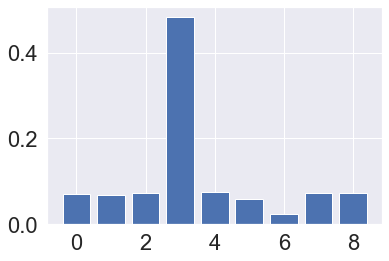

Number of trees: 200
Maximum depth: 32
Maximum features per node split: auto
              precision    recall  f1-score   support

         210       0.65      0.60      0.63        25
         215       0.58      0.64      0.61        22
         220       0.54      0.54      0.54        24
         225       0.77      0.77      0.77        22

    accuracy                           0.63        93
   macro avg       0.64      0.64      0.64        93
weighted avg       0.64      0.63      0.63        93

Feature: 0, Score: 0.06990
Feature: 1, Score: 0.07488
Feature: 2, Score: 0.07173
Feature: 3, Score: 0.46538
Feature: 4, Score: 0.07732
Feature: 5, Score: 0.06375
Feature: 6, Score: 0.02720
Feature: 7, Score: 0.07446
Feature: 8, Score: 0.07538


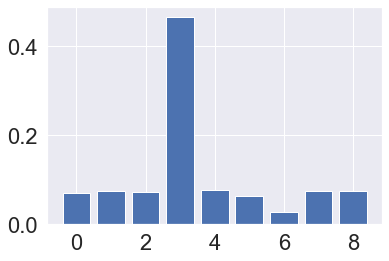

Number of trees: 1000
Maximum depth: 32
Maximum features per node split: auto
              precision    recall  f1-score   support

         210       0.74      0.68      0.71        25
         215       0.57      0.59      0.58        22
         220       0.67      0.80      0.73        20
         225       0.78      0.69      0.73        26

    accuracy                           0.69        93
   macro avg       0.69      0.69      0.69        93
weighted avg       0.69      0.69      0.69        93

Done in 778.4053795337677 seconds


In [30]:
tic = time.time()

# Split in K folds
cv = StratifiedKFold(n_splits=K, shuffle=True, random_state=13)
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
        
    # Optimize hyperparameters
    hyperparameters = {"n_estimators": [200, 1000, 2000], \
                       "max_depth": [int(x) for x in np.linspace(10, 100, num = 5)],\
                       "max_features": ['auto', 'sqrt']}
    gkf=StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
    Grid = GridSearchCV(RandomForestClassifier(), hyperparameters, scoring='accuracy', cv=gkf, verbose=0, n_jobs=-1)
    Grid.fit(X_train, y_train)
    
    # Initiating a RF classifier
    RFC = RandomForestClassifier(n_estimators = Grid.best_params_['n_estimators'], \
                                max_depth = Grid.best_params_['max_depth'], \
                                max_features = Grid.best_params_['max_features'], random_state = 13)  

    # Fit model
    RFC.fit(X_train, y_train)
  
    # performing predictions on the test dataset
    y_pred = RFC.predict(X_test)
    
    # Summarize feature importance
    importance = RFC.feature_importances_
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Output
    print(f"\033[1mNumber of trees: \033[0m{Grid.best_params_['n_estimators']}")
    print(f"\033[1mMaximum depth: \033[0m{Grid.best_params_['max_depth']}")
    print(f"\033[1mMaximum features per node split: \033[0m{Grid.best_params_['max_features']}")
    print(classification_report(y_pred, y_test))
    
    # Model performance
    accuracy = float(classification_report(y_pred, y_test)[-123:-119])
    precision = float(classification_report(y_pred, y_test)[-35:-31])
    recall = float(classification_report(y_pred, y_test)[-25:-21])
        
    # Save in dataframe
    row = pd.DataFrame([accuracy, precision, recall, 'RF',  n_channels, table], \
                   index = ['accuracy', 'precision', 'recall', 'classifier', 'n_channels', 'table']).transpose()
    performance = performance.append(row, ignore_index=True)  

print(f'Done in {time.time()-tic} seconds')    

# V. Statistics

In [31]:
# Typecast dataframe
performance[['classifier', 'n_channels', 'table']] = performance[['classifier', 'n_channels', 'table']].astype('category')
performance[['accuracy', 'precision', 'recall']] = performance[['accuracy', 'precision', 'recall']].astype('float32')

# Save as csv
df.to_csv('df_table3.csv')
performance.to_csv('performance_table3.csv')

# Display
display(performance)
display(df)

,accuracy,precision,recall,classifier,n_channels,table
0,0.49,0.53,0.49,log,13,3
1,0.55,0.61,0.55,log,13,3
2,0.34,0.37,0.34,log,13,3
3,0.43,0.49,0.43,log,13,3
4,0.54,0.57,0.54,log,13,3
5,0.36,0.43,0.36,ridge,13,3
6,0.55,0.70,0.55,ridge,13,3
7,0.30,0.38,0.30,ridge,13,3
8,0.37,0.53,0.37,ridge,13,3
9,0.50,0.64,0.50,ridge,13,3


,subject,day,target,offset,knee,exponent,CF,PW,BW,n_peaks,r_squared,error
0,S1,/Day1,210,-2.786069,-1.013677,0.005934,19.586790,0.252773,3.550318,3,0.971973,0.044624
1,S1,/Day1,215,-3.434262,-1.003559,0.001554,20.185457,0.223581,3.162583,3,0.973995,0.044684
2,S1,/Day1,220,-1.130506,-1.598865,0.205102,21.920685,0.298087,2.000000,3,0.971127,0.049268
3,S1,/Day1,225,-4.173462,-1.000673,0.000297,20.296577,0.213252,4.000000,5,0.969226,0.047616
4,S1,/Day2,210,-3.396288,-1.002890,0.001265,18.440058,0.231410,2.214785,4,0.966493,0.044092
...,...,...,...,...,...,...,...,...,...,...,...,...
463,S30,/Day1,220,1.592971,5.640302,1.131878,22.673483,0.216622,4.000000,3,0.856644,0.066957
464,S30,/Day1,225,4.014735,6070.843750,2.574229,22.298964,0.354434,2.000000,3,0.879738,0.067575
465,S30,/Day2,215,5.583467,361304.375000,3.439167,21.107946,0.234920,2.000000,4,0.924883,0.042138
466,S30,/Day2,220,4.742969,40169.644531,2.990928,21.825737,0.407879,2.000000,2,0.747785,0.094793


In [32]:
# Mean
display(pd.concat([performance.groupby(['classifier', 'n_channels']).agg({'accuracy': ['mean']}),\
                   performance.groupby(['classifier', 'n_channels']).agg({'precision': ['mean']}),\
                   performance.groupby(['classifier', 'n_channels']).agg({'recall': ['mean']})], axis=1))

# Standard error
print('log 13')
display(np.std(performance[(performance['classifier']=='log') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('log 3')
display(np.std(performance[(performance['classifier']=='log') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('Ridge 13')
display(np.std(performance[(performance['classifier']=='ridge') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('Ridge 3')
display(np.std(performance[(performance['classifier']=='ridge') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('KNN 13')
display(np.std(performance[(performance['classifier']=='KNN') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('KNN 3')
display(np.std(performance[(performance['classifier']=='KNN') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('MLP 13')
display(np.std(performance[(performance['classifier']=='MLP') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('MLP 3')
display(np.std(performance[(performance['classifier']=='MLP') & (performance['n_channels']==3)], axis=0)/sqrt(5))

print('RF 13')
display(np.std(performance[(performance['classifier']=='RF') & (performance['n_channels']==13)], axis=0)/sqrt(5))
print('RF 3')
display(np.std(performance[(performance['classifier']=='RF') & (performance['n_channels']==3)], axis=0)/sqrt(5))

accuracy precision recall
                          mean      mean   mean
classifier n_channels                          
KNN        3             0.444     0.460  0.444
           13            0.352     0.384  0.352
MLP        3             0.638     0.650  0.638
           13            0.572     0.600  0.572
RF         3             0.712     0.728  0.712
           13            0.624     0.640  0.624
log        3             0.528     0.564  0.528
           13            0.470     0.514  0.470
ridge      3             0.486     0.632  0.486
           13            0.416     0.536  0.416

log 13


accuracy     0.034756
precision    0.036835
recall       0.034756
dtype: float64

log 3


accuracy     0.005215
precision    0.014588
recall       0.005215
dtype: float64

Ridge 13


accuracy     0.041819
precision    0.054155
recall       0.041819
dtype: float64

Ridge 3


accuracy     0.012522
precision    0.019880
recall       0.012522
dtype: float64

KNN 13


accuracy     0.031164
precision    0.030542
recall       0.031164
dtype: float64

KNN 3


accuracy     0.018022
precision    0.018974
recall       0.018022
dtype: float64

MLP 13


accuracy     0.020080
precision    0.017436
recall       0.020080
dtype: float64

MLP 3


accuracy     0.020278
precision    0.024819
recall       0.020278
dtype: float64

RF 13


accuracy     0.009209
precision    0.010954
recall       0.009209
dtype: float64

RF 3


accuracy     0.023900
precision    0.027335
recall       0.023900
dtype: float64

In [33]:
## ANOVA and Tukey's test 
# Accuracy
model = ols('accuracy ~ C(classifier) + C(n_channels) + C(classifier):C(n_channels)', data=performance).fit()
display(sm.stats.anova_lm(model, typ=2))
tukey = pairwise_tukeyhsd(endog=performance['accuracy'],
                          groups=performance['classifier'],
                          alpha=0.05)
print(tukey)
tukey = pairwise_tukeyhsd(endog=performance['accuracy'],
                          groups=performance['n_channels'],
                          alpha=0.05)
print(tukey)

# Precision
model = ols('precision ~ C(classifier) + C(n_channels) + C(classifier):C(n_channels)', data=performance).fit()
display(sm.stats.anova_lm(model, typ=2))
tukey = pairwise_tukeyhsd(endog=performance['precision'],
                          groups=performance['classifier'],
                          alpha=0.05)
print(tukey)
tukey = pairwise_tukeyhsd(endog=performance['precision'],
                          groups=performance['n_channels'],
                          alpha=0.05)
print(tukey)

# Recall
model = ols('recall ~ C(classifier) + C(n_channels) + C(classifier):C(n_channels)', data=performance).fit()
display(sm.stats.anova_lm(model, typ=2))
tukey = pairwise_tukeyhsd(endog=performance['recall'],
                          groups=performance['classifier'],
                          alpha=0.05)
print(tukey)
tukey = pairwise_tukeyhsd(endog=performance['recall'],
                          groups=performance['n_channels'],
                          alpha=0.05)
print(tukey)

,sum_sq,df,F,PR(>F)
C(classifier),0.491268,4.0,33.265703,3.100056e-12
C(n_channels),0.069938,1.0,18.943117,9.068502e-05
C(classifier):C(n_channels),0.002132,4.0,0.144366,9.644449e-01
Residual,0.147680,40.0,NaN,NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   KNN    MLP    0.207  0.001  0.1182  0.2958   True
   KNN     RF     0.27  0.001  0.1812  0.3588   True
   KNN    log    0.101 0.0186  0.0122  0.1898   True
   KNN  ridge    0.053 0.4483 -0.0358  0.1418  False
   MLP     RF    0.063 0.2753 -0.0258  0.1518  False
   MLP    log   -0.106 0.0121 -0.1948 -0.0172   True
   MLP  ridge   -0.154  0.001 -0.2428 -0.0652   True
    RF    log   -0.169  0.001 -0.2578 -0.0802   True
    RF  ridge   -0.217  0.001 -0.3058 -0.1282   True
   log  ridge   -0.048 0.5399 -0.1368  0.0408  False
----------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     3     13  -0.0748 0.0266 -0.1405 -0.0091   True
----------------------------------------------

,sum_sq,df,F,PR(>F)
C(classifier),0.390788,4.0,19.594263,5.363131e-09
C(n_channels),0.064800,1.0,12.996389,8.552691e-04
C(classifier):C(n_channels),0.004540,4.0,0.227637,9.213061e-01
Residual,0.199440,40.0,NaN,NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   KNN    MLP    0.203  0.001  0.1048  0.3012   True
   KNN     RF    0.262  0.001  0.1638  0.3602   True
   KNN    log    0.117 0.0123  0.0188  0.2152   True
   KNN  ridge    0.162  0.001  0.0638  0.2602   True
   MLP     RF    0.059 0.4417 -0.0392  0.1572  False
   MLP    log   -0.086 0.1116 -0.1842  0.0122  False
   MLP  ridge   -0.041 0.7337 -0.1392  0.0572  False
    RF    log   -0.145 0.0011 -0.2432 -0.0468   True
    RF  ridge     -0.1 0.0441 -0.1982 -0.0018   True
   log  ridge    0.045 0.6696 -0.0532  0.1432  False
----------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     3     13   -0.072 0.0267 -0.1353 -0.0087   True
----------------------------------------------

,sum_sq,df,F,PR(>F)
C(classifier),0.491268,4.0,33.265703,3.100056e-12
C(n_channels),0.069938,1.0,18.943117,9.068502e-05
C(classifier):C(n_channels),0.002132,4.0,0.144366,9.644449e-01
Residual,0.147680,40.0,NaN,NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   KNN    MLP    0.207  0.001  0.1182  0.2958   True
   KNN     RF     0.27  0.001  0.1812  0.3588   True
   KNN    log    0.101 0.0186  0.0122  0.1898   True
   KNN  ridge    0.053 0.4483 -0.0358  0.1418  False
   MLP     RF    0.063 0.2753 -0.0258  0.1518  False
   MLP    log   -0.106 0.0121 -0.1948 -0.0172   True
   MLP  ridge   -0.154  0.001 -0.2428 -0.0652   True
    RF    log   -0.169  0.001 -0.2578 -0.0802   True
    RF  ridge   -0.217  0.001 -0.3058 -0.1282   True
   log  ridge   -0.048 0.5399 -0.1368  0.0408  False
----------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     3     13  -0.0748 0.0266 -0.1405 -0.0091   True
----------------------------------------------